In [1]:
from langchain_community.llms import Ollama
from langchain_community.chat_models import ChatOllama

# pip install langchain-core>=0.3.70

In [17]:
import sqlite3
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
# from langchain_community.chat_models import ChatOllama
from langchain_ollama import ChatOllama

llm = ChatOllama(model="mistral")

In [ ]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END

# Your Groq API key
groq_api_key = "DUMMY_API_KEY"

# Create the Groq chat model
llm = ChatGroq(
    api_key=groq_api_key,
    model="llama-3.1-8b-instant",   # Groq's popular free model
    temperature=0
)

# llm = ChatOpenAI(model="gpt-4o", temperature=0)
# llm = ChatOllama(model="mistral", temperature=0)

In [45]:
import sqlite3
import random
from faker import Faker

# Create DB
db_path = r"D:\chatbot\onx_focus.db"

conn = sqlite3.connect(db_path)
cursor = conn.cursor()


# Drop existing table if exists
cursor.execute("DROP TABLE IF EXISTS global_users")

# Create table
cursor.execute("""
CREATE TABLE global_users (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT,
    age INTEGER,
    gender TEXT,
    email TEXT,
    phone TEXT,
    country TEXT,
    city TEXT,
    language TEXT,
    occupation TEXT,
    company TEXT,
    salary INTEGER,
    marital_status TEXT,
    is_active INTEGER,
    registration_date TEXT
)
""")

# Setup Faker
Faker.seed(123)
fake = Faker('en_US')  # locale specified directly here

countries = ["USA", "India", "Germany", "Japan", "Brazil", "South Africa", "Australia", "UK", "Canada", "China"]
languages = ["English", "Hindi", "German", "Japanese", "Portuguese", "Zulu", "Mandarin", "French", "Spanish", "Arabic"]
occupations = ["Engineer", "Teacher", "Doctor", "Artist", "Developer", "Manager", "Chef", "Nurse", "Designer", "Writer"]
marital_statuses = ["Single", "Married", "Divorced", "Widowed"]

# Insert 100 rows
for _ in range(100):
    name = fake.name()
    age = random.randint(20, 70)
    gender = random.choice(["Male", "Female", "Other"])
    email = fake.email()
    phone = fake.phone_number()
    country = random.choice(countries)
    city = fake.city()
    language = random.choice(languages)
    occupation = random.choice(occupations)
    company = fake.company()
    salary = random.randint(30000, 150000)
    marital_status = random.choice(marital_statuses)
    is_active = random.choice([0, 1])
    registration_date = fake.date_this_decade().isoformat()

    cursor.execute("""
    INSERT INTO global_users (
        name, age, gender, email, phone,
        country, city, language, occupation, company,
        salary, marital_status, is_active, registration_date
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        name, age, gender, email, phone,
        country, city, language, occupation, company,
        salary, marital_status, is_active, registration_date
    ))

# Commit and close
conn.commit()
conn.close()

print("Database 'onx_focus.db' with 100 global records created.")

Database 'onx_focus.db' with 100 global records created.


In [46]:
# Connect to SQLite
conn = sqlite3.connect(r"D:\chatbot\onx_focus.db")

# ----- PROMPT TEMPLATE -----
sql_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert SQL developer. "
            "Your job is to write an SQLite SQL query that answers the user's question, "
            "given the database schema provided. "
            "Follow these rules strictly:\n"
            "1. Do not explain anything — only provide valid SQL code.\n"
            "2. Wrap ALL table names and column names in double quotes.\n"
            "   For example:\n"
            "      SELECT \"name\", \"age\" FROM \"users\";\n"
            "3. Use WHERE clauses only when required to answer the question.\n"
            "4. If the user requests all columns, use SELECT * FROM ...\n"
            "5. Do not add comments or natural language in your output.\n"
            "6. Return only pure SQL syntax, no markdown or ```sql blocks."
        ),
        (
            "human",
            "Database schema:\n{schema}\n\nUser question:\n{question}"
        )
    ]
)

# Get DB schema as text
def get_schema(conn):
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    schema = ""
    for table_name, in tables:
        cursor.execute(f"PRAGMA table_info({table_name});")
        cols = cursor.fetchall()
        schema += f"Table {table_name}:\n"
        for col in cols:
            schema += f"  {col[1]} {col[2]}\n"
        schema += "\n"
    return schema

schema_text = get_schema(conn)

In [47]:
# ----- LangGraph Nodes -----

# 1. Node: Generate SQL
def generate_sql(state):
    question = state["question"]
    
    prompt = sql_prompt.format(schema=schema_text, question=question)
    sql_query = llm.invoke(prompt).content.strip()
    
    # Remove code blocks if LLM returns ```sql ... ```
    if sql_query.startswith("```"):
        sql_query = sql_query.strip("`").strip().split("\n", 1)[-1]
    
    state["sql_query"] = sql_query
    return state

In [48]:
# 2. Node: Execute SQL
def execute_sql(state):
    sql_query = state["sql_query"]
    
    try:
        cursor = conn.cursor()
        cursor.execute(sql_query)
        rows = cursor.fetchall()
        state["result"] = rows
    except Exception as e:
        state["result"] = f"SQL Execution error: {str(e)}"
    
    return state

In [41]:
# 3. Node: Format Response
def format_result(state):
    rows = state["result"]
    
    if isinstance(rows, str):
        # Error string
        state["answer"] = rows
    elif rows:
        # Format rows as text table
        formatted = "\n".join(str(row) for row in rows)
        state["answer"] = f"Query results:\n{formatted}"
    else:
        state["answer"] = "Query returned no results."
    
    return state

In [42]:
# ----- Build the Graph -----

# Define graph
graph = StateGraph(state_schema=dict)

graph.add_node("GenerateSQL", generate_sql)
graph.add_node("ExecuteSQL", execute_sql)
graph.add_node("FormatResult", format_result)

# Connect nodes
graph.set_entry_point("GenerateSQL")
graph.add_edge("GenerateSQL", "ExecuteSQL")
graph.add_edge("ExecuteSQL", "FormatResult")
graph.add_edge("FormatResult", END)

# Compile graph
runnable = graph.compile()

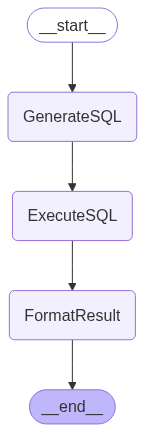

In [50]:
from IPython.display import Image, display
try:
    display(Image(runnable.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [57]:
user_question = "How many users are from India?"

# Initial state
state = {"question": user_question}

final_state = runnable.invoke(state)

# print("SQL Query:\n", final_state["sql_query"])
# print("\nFinal Answer:\n", final_state["answer"])
final_state

{'question': 'How many users are from India?',
 'sql_query': 'SELECT COUNT(*) FROM "global_users" WHERE "country" = \'India\'',
 'result': [(15,)],
 'answer': 'Query results:\n(15,)'}

In [56]:
print("SQL Query:\n", final_state["sql_query"])
print("\nFinal Answer:\n", final_state["answer"])

SQL Query:
 SELECT "name", "email" FROM "global_users" WHERE "is_active" = 1

Final Answer:
 Query results:
('Brandon Russell', 'robersonnancy@example.com')
('Nicholas Garcia', 'davisdouglas@example.org')
('Katelyn Barnett', 'william21@example.com')
('Deborah Williams', 'blanchardwilliam@example.org')
('Tammy Rogers', 'whiteandrew@example.net')
('Andrew Smith', 'jamesadams@example.org')
('Alexander Ward', 'stevenperry@example.net')
('Andrew Gonzales', 'lisayoung@example.com')
('Mark Jones', 'jennifersimmons@example.com')
('Brandon Green', 'wadedavid@example.com')
('Susan Martin', 'volson@example.com')
('Phillip Perkins', 'nkrueger@example.com')
('Dr. Timothy Sullivan MD', 'laurareynolds@example.net')
('Frank Jones', 'cody70@example.org')
('Kyle Moore', 'sean95@example.net')
('Gary Clark', 'georgemendez@example.com')
('Matthew Gilmore', 'jakesanchez@example.org')
('Benjamin Ruiz', 'seanyoung@example.com')
('Michael Salas', 'johnsonheather@example.net')
('Douglas Thomas', 'hammondleah@ex

In [ ]:
CREATE TABLE users (
    id INTEGER PRIMARY KEY,
    name TEXT,
    age INTEGER,
    city TEXT
);

INSERT INTO users (name, age, city) VALUES
('Alice', 30, 'New York'),
('Bob', 25, 'San Francisco'),
('Carol', 40, 'Boston');


In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage("Translate the following from English into Italian"),
    HumanMessage("hi!"),
]

model.invoke(messages)